# XceptNet Transfer Learning Model using Tensorflow-Keras

### TUTORIAL

- Feature Extraction and Fine-tuning:
    https://www.tensorflow.org/guide/keras/transfer_learning
- Transfer Learning and Fine-turning Guide:
    https://www.tensorflow.org/tutorials/images/transfer_learning

## Import Necessary Libraries

In [1]:
%cd D:\CVOps\angkorice-vision

D:\CVOps\angkorice-vision


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from pathlib import Path
from sklearn.utils import class_weight

## Data Preprocessing

In [3]:
# Train and Test folder path
TRAIN_DIR = r'dataset/processed/rice_leaf_vision/v1.0/train'
VALID_DIR = r'dataset/processed/rice_leaf_vision/v1.0/valid'
TEST_DIR = r'dataset/processed/rice_leaf_vision/v1.0/test'

IMG_SIZE = (299, 299)
BATCH_SIZE = 32
train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    shuffle = True,
    batch_size = BATCH_SIZE,
    image_size = IMG_SIZE
)
test_ds = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR,
    shuffle = True,
    batch_size = BATCH_SIZE,
    image_size = IMG_SIZE
)
valid_ds = tf.keras.utils.image_dataset_from_directory(
    VALID_DIR,
    shuffle = False,
    batch_size = BATCH_SIZE,
    image_size = IMG_SIZE
)

Found 6832 files belonging to 7 classes.
Found 980 files belonging to 7 classes.
Found 1953 files belonging to 7 classes.


In [9]:
cls_names = train_ds.class_names
print(cls_names)

['Bacterialblight', 'Blast', 'Brownspot', 'Healthyleaf', 'Leafscald', 'Sheathblight', 'Tungro']


In [8]:
for i, labels in enumerate(train_ds.class_names):
    print(f"{i} : {labels}")
    continue



0 : Bacterialblight
1 : Blast
2 : Brownspot
3 : Healthyleaf
4 : Leafscald
5 : Sheathblight
6 : Tungro


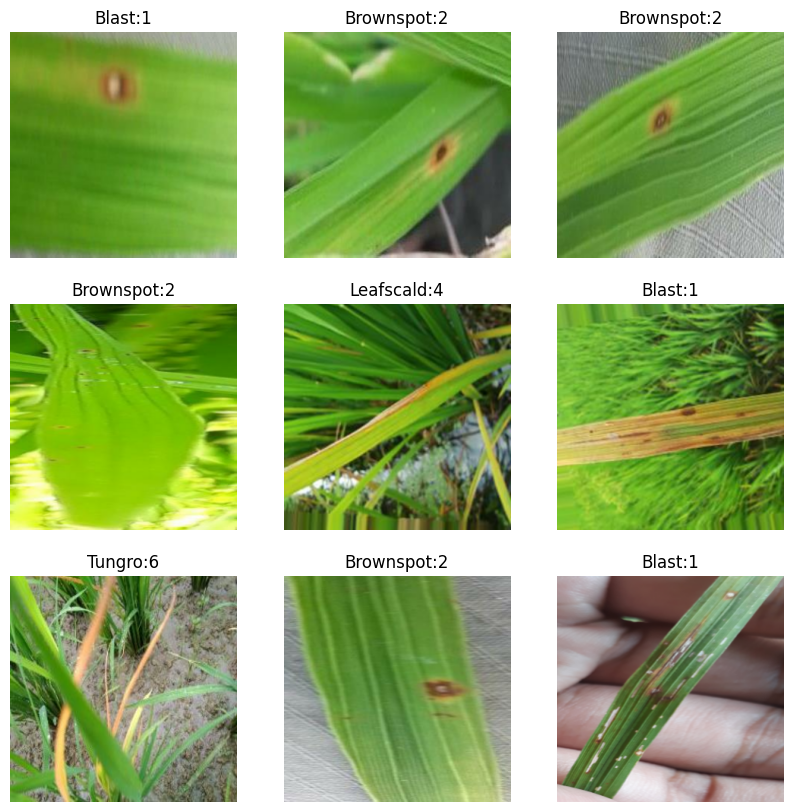

In [4]:
class_name = train_ds.class_names

plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"{class_name[labels[i]]}:{labels[i]}")
        plt.axis('off')

## Configure data for performance

In [5]:
# Data Performance:  https://www.tensorflow.org/guide/data_performance
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)
valid_ds = valid_ds.prefetch(buffer_size=AUTOTUNE)

### Data Augmentation

In [6]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
])
# tf.keras.Sequential(layer1, layer2)


### Visualize augmented images

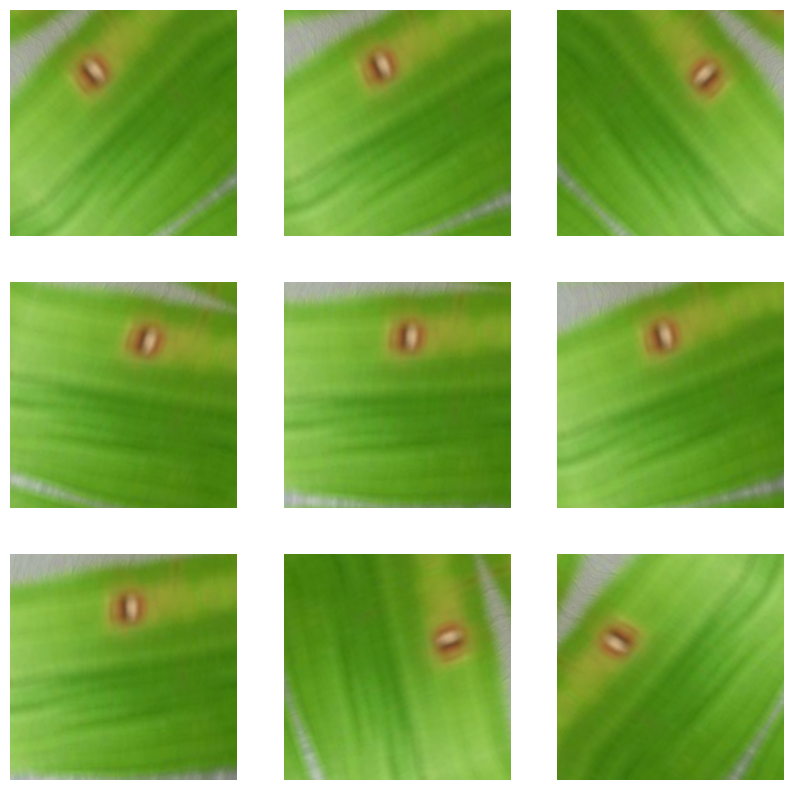

In [7]:
for image, _ in train_ds.take(1):
  plt.figure(figsize=(10,10))
  first_image = images[0]
  for i in range(9):
    ax = plt.subplot(3,3, i+1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

##  Create the base model from the pre-trained convnets

### Rescale the image from from [0, 255] to [-1, 1] as per the pre-trained Xception Model required.

In [8]:
# Create the base mode from the pretrained model Xception

preprocess_input = tf.keras.applications.xception.preprocess_input
# Note: Alternatively, you could rescale pixel values from [0, 255] to [-1, 1] using tf.keras.layers.Rescaling.
# rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

### Create the base model

In [9]:
# Create the base model from the pre-trained model Xception

IMG_SHAPE = IMG_SIZE + (3, ) # Adding the number of channel (RGB)
base_model = tf.keras.applications.Xception(input_shape=IMG_SHAPE,
                                            include_top=False, # Exclude classifier head
                                            weights='imagenet')

In [10]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 10, 10, 2048)


### Freeze the convolutional base

It is important to freeze the convolutional base before you compile and train the model. Freezing (by setting layer.trainable = False) prevents the weights in a given layer from being updated during training. MobileNet V2 has many layers, so setting the entire model's trainable flag to False will freeze all of them.

In [11]:
base_model.trainable = False

## Feature Extraction and Fine-Tuning Procedure

- When we freeze the base_model (base_model.trainable=False) --> Feature Extraction
- Unfreeze the trainable weights or any top layers --> Fine-tuning the model
Why?
 Because at the earlier layers, the pre-trained mode learnt the general feature from, example, ImageNet. Moreover, at the top layers, pre-trained model learn to adapt the new feature of the dataset.

### Feature Extraction
Many models contain tf.keras.layers.BatchNormalization layers. This layer is a special case and precautions should be taken in the context of fine-tuning, as shown later in this tutorial.

When you set layer.trainable = False, the BatchNormalization layer will run in inference mode, and will not update its mean and variance statistics.

When you unfreeze a model that contains BatchNormalization layers in order to do fine-tuning, you should keep the BatchNormalization layers in inference mode by passing training = False when calling the base model. Otherwise, the updates applied to the non-trainable weights will destroy what the model has learned.

In [12]:
# The base model Summary
base_model.summary()

Model: "xception"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 299, 299,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 149, 149,  │        864 │ input_layer_1[0]… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, 149, 149,  │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, 149, 149,  │          0 │ block1_conv1_bn[… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 147, 147,  │     18,432 │ block1_conv1_act… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, 147, 147,  │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, 147, 147,  │          0 │ block1_conv2_bn[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1     │ (None, 147, 147,  │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, 147, 147,  │        512 │ block2_sepconv1[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_act │ (None, 147, 147,  │          0 │ block2_sepconv1_… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2     │ (None, 147, 147,  │     17,536 │ block2_sepconv2_… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, 147, 147,  │        512 │ block2_sepconv2[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 74, 74,    │      8,192 │ block1_conv2_act… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 74, 74,    │          0 │ block2_sepconv2_… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 74, 74,    │        512 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 74, 74,    │          0 │ block2_pool[0][0… │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_sepconv1_act │ (None, 74, 74,    │          0 │ add[0][0]       

 Total params: 20,861,480 (79.58 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 20,861,480 (79.58 MB)

We saw; Trainable params : 0 due to we frozen all the trainable parameters (*base_model.trainable=False*)

### Add a classification Head

To generate predictions from the block of features, average over the spatial 10x10 spatial locations, using a tf.keras.layers.GlobalAveragePooling2D layer to convert the features to a single 1280-element vector per image.

In [13]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D() # convert the the features to a single 2048-element vecotr per image
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 2048)


In [14]:
print(len(class_name))

7


In [15]:
prediction_layer = tf.keras.layers.Dense(len(class_name), activation='softmax')
prediction_batch = prediction_layer(feature_batch)
print(prediction_batch.shape)

(32, 10, 10, 7)


Build a model by chaining together the data augmentation, rescaling, base_model and feature extractor layers using the Keras Functional API. As previously mentioned, use training=False as our model contains a BatchNormalization layer.

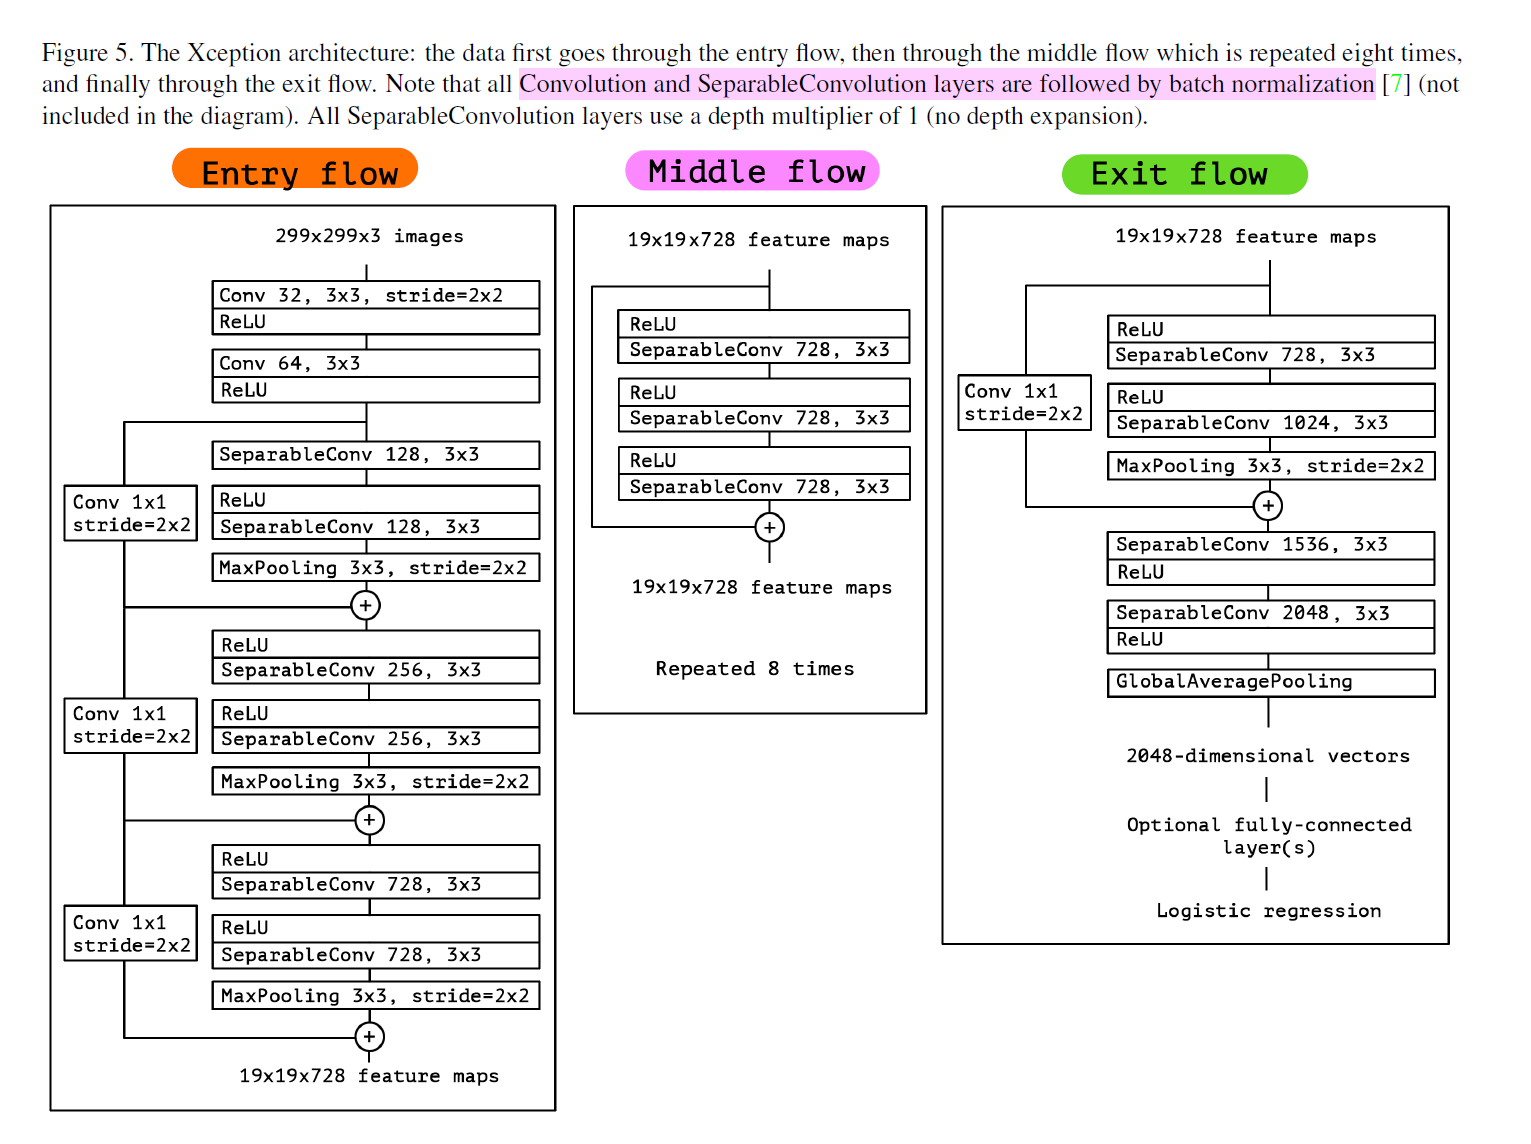

In [16]:
inputs = tf.keras.Input(shape = (299, 299, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [17]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 299, 299, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 299, 299, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 299, 299, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 299, 299, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ xception (Functional)           │ (None, 10, 10, 2048)   │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 7)              │        14,343 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,875,823 (79.63 MB)

 Trainable params: 14,343 (56.03 KB)

 Non-trainable params: 20,861,480 (79.58 MB)

The 20+ million parameters in Xception are frozen, but there are 14 thousand trainable parameters in the Dense layer. These are divided between two tf.Variable objects, the weights and biases.

In [18]:
len(model.trainable_variables)

2

In [19]:
!pip install graphviz pydot

  Using cached graphviz-0.21-py3-none-any.whl.metadata (12 kB)
Using cached graphviz-0.21-py3-none-any.whl (47 kB)


In [20]:
from tensorflow.keras.utils import plot_model

plot_model(
    model,
    show_shapes=True,
    show_layer_names=True,
    expand_nested=True
)


### Create a class weight for Imbalance class dataset

In [21]:
from sklearn.utils import class_weight
import numpy as np

# Labels from the dataset
y = np.concat([labels.numpy() for _, label in train_ds])

# Compute class weights
weights_array = class_weight.compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y),
    y=y
)
# Convert to dictionary for Keras
class_weights = dict(enumerate(weights_array))
print(class_weights)

{0: np.float64(0.7619047619047619), 1: np.float64(0.5714285714285714), 2: np.float64(0.9142857142857143), 3: np.float64(1.5238095238095237), 4: np.float64(1.5238095238095237), 5: np.float64(2.2857142857142856), 6: np.float64(0.9142857142857143)}


### Compile the Model

In [22]:
base_learning_rate = 0.0001
model.compile(
    optimizer= tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics = ['sparse_categorical_accuracy']
)
# Note: 
    # - CategoricalCrossentropy --> labels are one-hot encode
    # - SparseCategoricalCrossentropy --> labels are integer encoded. 
    # Example: y_true = [0, 1, 2]  # 0 = cat, 1 = dog, 2 = bird

### Model Training

#### Check the model performance before/ without Feature Extraction

In [23]:
initial_epochs = 15

loss0, accuracy0 = model.evaluate(valid_ds)

62/62 ━━━━━━━━━━━━━━━━━━━━ 51s 809ms/step - loss: 1.9743 - sparse_categorical_accuracy: 0.1608


In [24]:
print("initial loss : {:.2f}".format(loss0))
print("initial accuracy : {:.2f}".format(accuracy0))

initial loss : 1.97
initial accuracy : 0.16


### Model training

In [25]:
history = model.fit(train_ds,
                    epochs = initial_epochs,
                    validation_data = valid_ds,
                    class_weight = class_weights)

Epoch 1/15
214/214 ━━━━━━━━━━━━━━━━━━━━ 229s 1s/step - loss: 1.6558 - sparse_categorical_accuracy: 0.3882 - val_loss: 1.4464 - val_sparse_categorical_accuracy: 0.5504
Epoch 2/15
214/214 ━━━━━━━━━━━━━━━━━━━━ 223s 1s/step - loss: 1.3279 - sparse_categorical_accuracy: 0.5665 - val_loss: 1.2191 - val_sparse_categorical_accuracy: 0.6252
Epoch 3/15
214/214 ━━━━━━━━━━━━━━━━━━━━ 223s 1s/step - loss: 1.1418 - sparse_categorical_accuracy: 0.6326 - val_loss: 1.0844 - val_sparse_categorical_accuracy: 0.6795
Epoch 4/15
214/214 ━━━━━━━━━━━━━━━━━━━━ 222s 1s/step - loss: 1.0401 - sparse_categorical_accuracy: 0.6600 - val_loss: 1.0003 - val_sparse_categorical_accuracy: 0.7005
Epoch 5/15
214/214 ━━━━━━━━━━━━━━━━━━━━ 222s 1s/step - loss: 0.9568 - sparse_categorical_accuracy: 0.6822 - val_loss: 0.9358 - val_sparse_categorical_accuracy: 0.7133
Epoch 6/15
214/214 ━━━━━━━━━━━━━━━━━━━━ 222s 1s/step - loss: 0.8988 - sparse_categorical_accuracy: 0.7029 - val_loss: 0.8908 - val_sparse_categorical_accuracy: 0.719

## Fine Tuning 

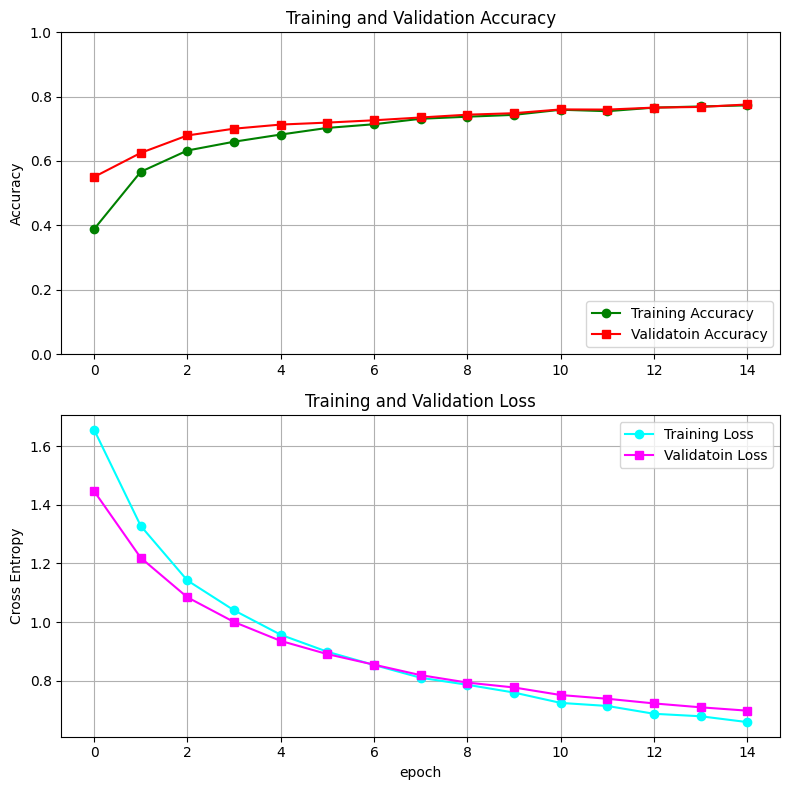

In [26]:
acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8,8))
plt.subplot(2,1,1) #n_row, n_col, andix
plt.plot(acc, label='Training Accuracy',  color='green', marker='o')
plt.plot(val_acc, label='Validatoin Accuracy', color='red',  marker='s')
plt.legend(loc='lower right')
plt.grid(visible=True)
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.title('Training and Validation Accuracy')

plt.subplot(2,1,2)
plt.plot(loss, label='Training Loss', color='cyan', marker='o')
plt.plot(val_loss, label='Validatoin Loss', color='magenta',  marker='s')
plt.legend(loc='upper right')
plt.grid(visible=True)
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.tight_layout()
plt.show()


## Do a Round for Fine Tuning 

In [27]:
base_model.trainable = True

In [28]:
# Let's take a look to see how many layers are in the base model
print("Number of layser in the base model", len(base_model.layers))

Number of layser in the base model 132


In [29]:
# Fine-tune from this layer onwards
fine_tune_at =62

# Freeze all the layser before the 'fine_tune_at' layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

We fine-tun the last 78 layers out of Xception model's 132 layers.
By freeze the earlier layers at ' fine_tune_at', layer.trainable = False.
- RMSprop : is used by adjst base_learning_rate/10 (1e-5)

In [30]:
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),  # for 7 classes, integer labels
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]  # matches sparse labels
)


In [31]:
fine_tune_epochs = 15
total_epochs = initial_epochs + fine_tune_epochs

history_finetune = model.fit(train_ds,
                    epochs = total_epochs,
                    initial_epoch = len(history.epoch),
                    validation_data = valid_ds,
                    class_weight = class_weights)

Epoch 16/30
214/214 ━━━━━━━━━━━━━━━━━━━━ 422s 2s/step - loss: 0.7427 - sparse_categorical_accuracy: 0.7478 - val_loss: 0.5227 - val_sparse_categorical_accuracy: 0.8228
Epoch 17/30
214/214 ━━━━━━━━━━━━━━━━━━━━ 419s 2s/step - loss: 0.4816 - sparse_categorical_accuracy: 0.8271 - val_loss: 0.4247 - val_sparse_categorical_accuracy: 0.8633
Epoch 18/30
214/214 ━━━━━━━━━━━━━━━━━━━━ 415s 2s/step - loss: 0.3623 - sparse_categorical_accuracy: 0.8674 - val_loss: 0.3492 - val_sparse_categorical_accuracy: 0.8874
Epoch 19/30
214/214 ━━━━━━━━━━━━━━━━━━━━ 420s 2s/step - loss: 0.3095 - sparse_categorical_accuracy: 0.8927 - val_loss: 0.2973 - val_sparse_categorical_accuracy: 0.9007
Epoch 20/30
214/214 ━━━━━━━━━━━━━━━━━━━━ 420s 2s/step - loss: 0.2543 - sparse_categorical_accuracy: 0.9114 - val_loss: 0.2567 - val_sparse_categorical_accuracy: 0.9196
Epoch 21/30
214/214 ━━━━━━━━━━━━━━━━━━━━ 414s 2s/step - loss: 0.2278 - sparse_categorical_accuracy: 0.9191 - val_loss: 0.2259 - val_sparse_categorical_accuracy:

### Visualize the Fine Tuning Results

#### Combine the accuracy and loss in both trainings

In [32]:
acc += history_finetune.history['sparse_categorical_accuracy']
val_acc += history_finetune.history['val_sparse_categorical_accuracy']

loss +=history_finetune.history['loss']
val_loss +=history_finetune.history['val_loss']


#### Visualization

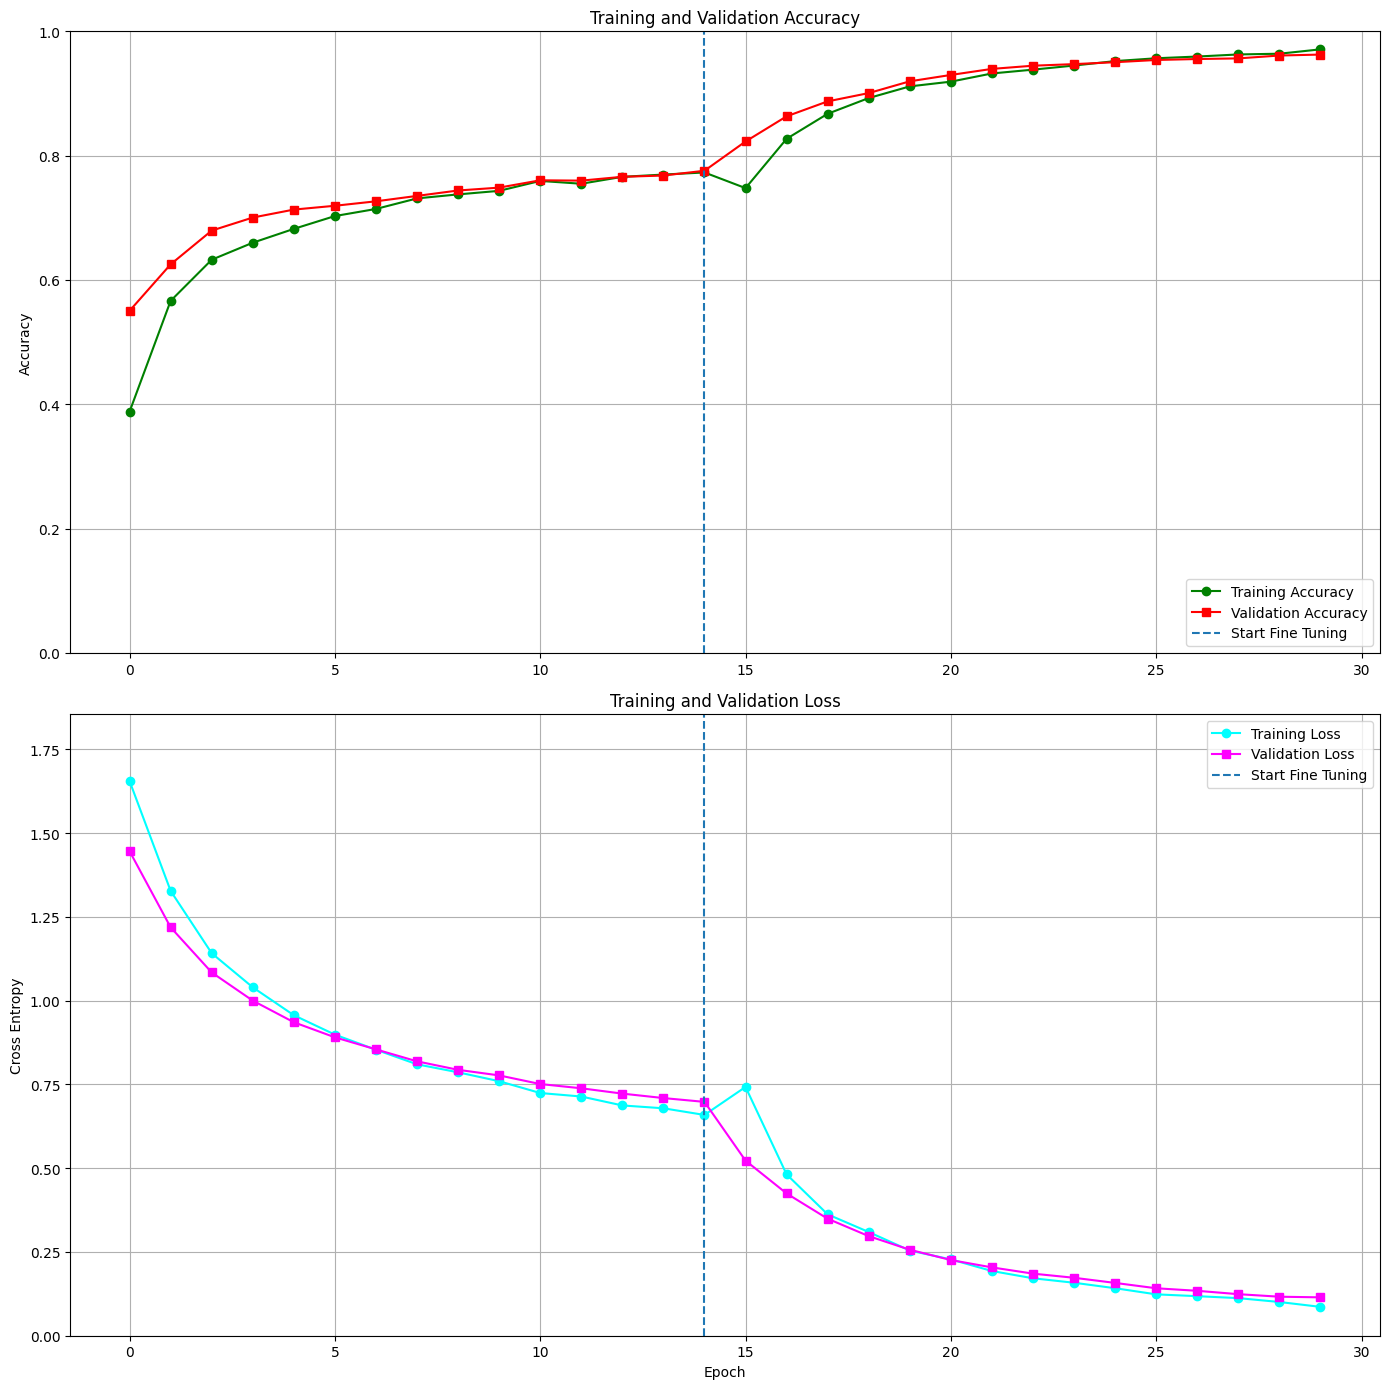

In [33]:

# Accuracy subplot
plt.figure(figsize=(14,14))
plt.subplot(2,1,1)
plt.plot(acc, label='Training Accuracy', color='green', marker='o')
plt.plot(val_acc, label='Validation Accuracy', color='red', marker='s')
plt.axvline(x=initial_epochs-1, color='tab:blue', label='Start Fine Tuning', linestyle='--')
plt.legend(loc='lower right')
plt.grid(True)
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.title('Training and Validation Accuracy')

# Loss subplot
plt.subplot(2,1,2)
plt.plot(loss, label='Training Loss', color='cyan', marker='o')
plt.plot(val_loss, label='Validation Loss', color='magenta', marker='s')
plt.axvline(x=initial_epochs-1, color='tab:blue', label='Start Fine Tuning', linestyle='--')
plt.legend(loc='upper right')
plt.grid(True)
plt.ylabel('Cross Entropy')
plt.xlabel('Epoch')

# Set ylim after plotting
plt.ylim(0, max(max(loss), max(val_loss)) + 0.2)
plt.title('Training and Validation Loss')

plt.tight_layout()
plt.show()


### Save the model

In [34]:
model.save("xception_fine_tuned_rice_leaf_model_30.keras")

### Load Model

In [35]:
ft_model = tf.keras.models.load_model(
    "xception_fine_tuned_rice_leaf_model_30.keras",
    compile=False
)


## Evaluation and Prediction

In [36]:
loss, accuracy = model.evaluate(test_ds)
print("Test Accuracy :", accuracy)
print("Test Loss :", loss)


31/31 ━━━━━━━━━━━━━━━━━━━━ 23s 750ms/step - loss: 0.1140 - sparse_categorical_accuracy: 0.9684
Test Accuracy : 0.968367338180542
Test Loss : 0.11396650969982147


Predicted class ids:
 [5 2 1 4 3 1 6 1 4 0 3 2 0 0 0 1 2 1 1 0 2 0 2 0 4 5 1 2 4 1 1 0]
True labels:
 [5 2 1 4 3 1 6 1 4 0 3 2 0 0 0 1 2 1 1 0 2 0 2 0 4 5 1 2 4 1 1 0]


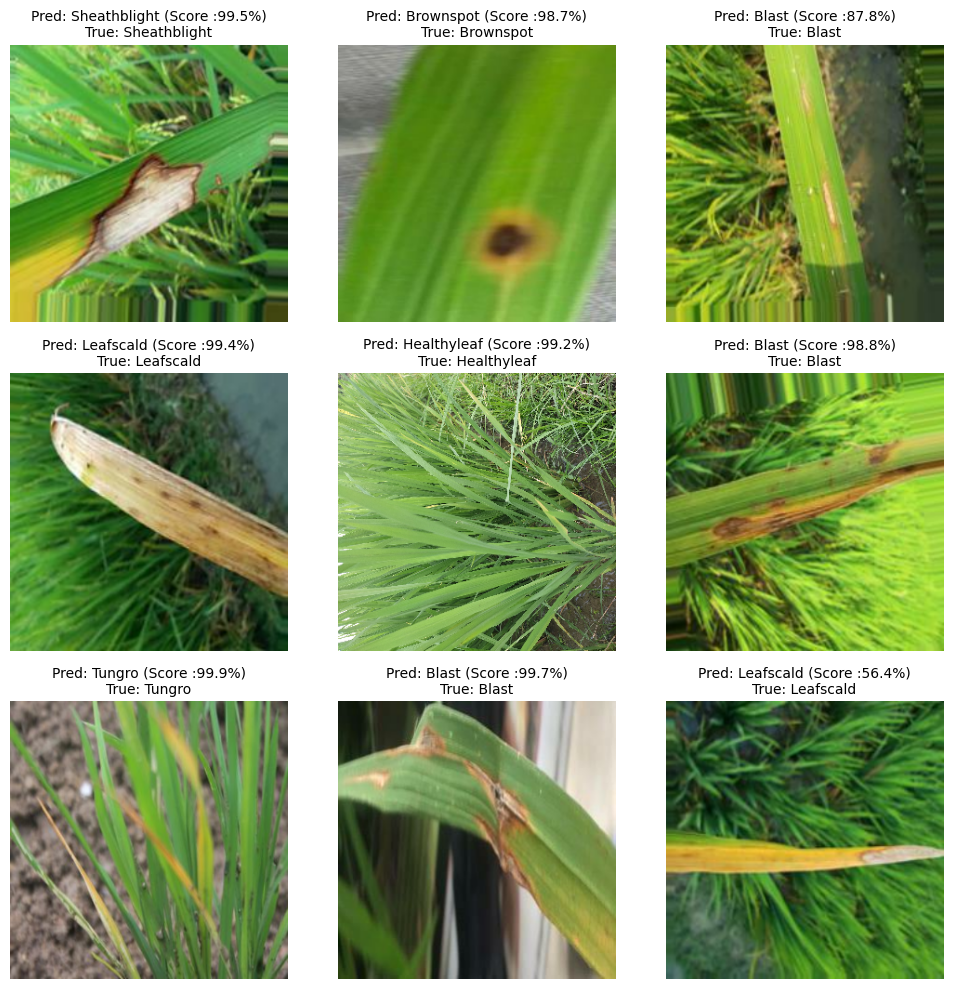

In [39]:
# Retrieve a batch from the validation set
class_names = train_ds.class_names
image_batch, label_batch = test_ds.as_numpy_iterator().next()

# Batch prediction (DO NOT flatten, DO NOT apply softmax again)
predictions = ft_model.predict_on_batch(image_batch)
# shape: (batch_size, num_classes)

# Get predicted class index + confidence
predicted_class_ids = tf.argmax(predictions, axis=1)
confidence_scores = tf.reduce_max(predictions, axis=1)

print("Predicted class ids:\n", predicted_class_ids.numpy())
print("True labels:\n", label_batch)

# Plot results
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))

    pred_label = class_names[predicted_class_ids[i]]
    confidence = confidence_scores[i] * 100
    true_label = class_names[label_batch[i]]

    plt.title(
        f"Pred: {pred_label} (Score :{confidence:.1f}%)\nTrue: {true_label}",
        fontsize=10
    )
    plt.axis("off")

plt.tight_layout()
plt.show()


### Prediction on The Whole Test Dataset

In [40]:
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = ft_model.predict(images, verbose=0)
    preds = tf.argmax(preds, axis=1)

    y_true.extend(labels.numpy())
    y_pred.extend(preds.numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)


### Image Classificaiton Report

In [41]:
from sklearn.metrics import classification_report

report = classification_report(
    y_true=y_true,
    y_pred=y_pred,
    labels=range(len(class_names)),   # 🔑 force all classes
    target_names=class_names,
    digits=4,
    zero_division=0                   # safe for missing classes
)

print(report)

with open("classification_report.txt", "w") as f:
    f.write(report)


                 precision    recall  f1-score   support

Bacterialblight     0.9682    0.9552    0.9616       223
          Blast     0.9949    0.9327    0.9628       208
      Brownspot     0.9737    0.9867    0.9801       225
    Healthyleaf     0.9851    1.0000    0.9925        66
      Leafscald     0.8310    0.9365    0.8806        63
   Sheathblight     0.9412    1.0000    0.9697        64
         Tungro     1.0000    1.0000    1.0000       131

       accuracy                         0.9684       980
      macro avg     0.9563    0.9730    0.9639       980
   weighted avg     0.9699    0.9684    0.9686       980



### Confusion Matrix

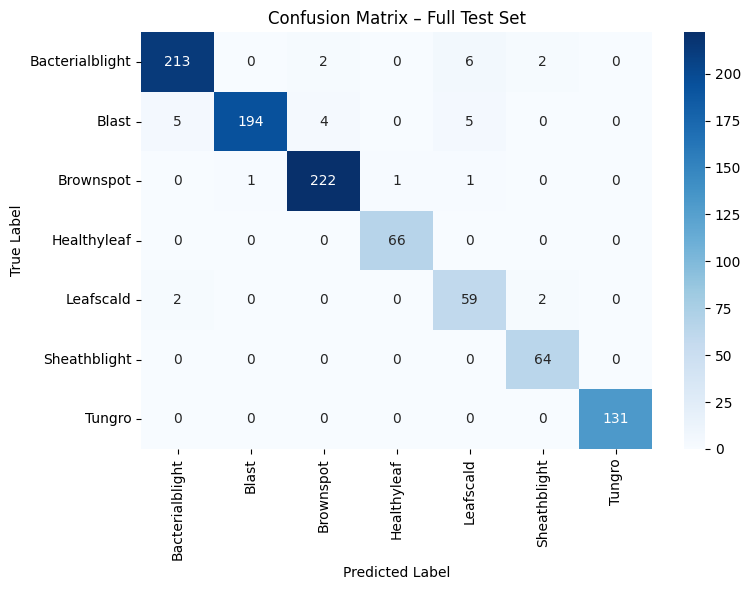

In [42]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(
    y_true=y_true,
    y_pred=y_pred,
    labels=range(len(class_names))
)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names
)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix – Full Test Set")
plt.tight_layout()
plt.show()


### Convert Keras Model to ONNX Model 

https://github.com/onnx/keras-onnx

In [17]:
results = [{
    "class_name" : "dog",
    "score" : 90.0
}]

In [18]:
for result in results:
    print(result["class_name"])
    print(result["score"])

dog
90.0


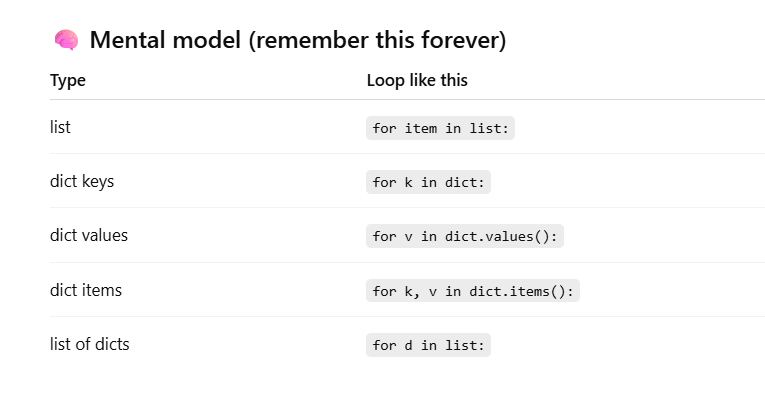